- leave running for 10+ hours to get ~50,000 tweets
- use keywords for scraping filter 
- try to figure something out relevant to content
- given sentiment analysis looks innaccurate - does it still correlate with favorable/unfavorable ranking (different from voting - how do you like them) Real Clear Politics does an average 
- how many pos/neg tweets per candidate --- compare against number of tweets, so could say ok trump has most tweets, but not all positive - compare 'who's winning on twitter'with poll data 
- can conclude candidate more popular on twitter than in polls, alt. is that twitter is good predictor for poll data 
- what are common topics ... topic clustering - does it vary by candidate? 

# First pass at exploring Twitter scraping
- used tweepy to scrape the data & output json file 

In [161]:
from pymongo import MongoClient
import json
import tweepy
from tweepy import Stream
from tweepy.streaming import StreamListener
import time
import numpy as np
import tweetExplore_fns as fns
import importlib
import matplotlib
import matplotlib.pyplot as plt

importlib.reload(fns);
%matplotlib inline



## organizing the data

In [67]:
#  import data 
# with open('raw_tweets10min.json') as data_file:
with open('../data/raw_tweetsfilter10min_poli.json') as data_file:
# with open('raw_tweets10min_loc.json') as data_file:
# with open('raw_tweets40min_bosSC.json') as data_file:
    rawdata = json.load(data_file)

# selects only tweets that have text 
tweet_list = fns.extract_tweets(rawdata)
        
#  extract indices for tweets that also have a fields of interest
coord_index_list = fns.extract_indices(tweet_list,"coordinates")

# extract tweets that also have a gps coordinate 
coord_tweet_list = fns.extract_tweets_fieldOfInterest(tweet_list,"coordinates")

print('N coordinates:',len(coord_index_list), 'N Tweets', len(tweet_list))

N coordinates: 10 N Tweets 10664


## Trying out the textblob sentiment analysis

In [247]:
from textblob import TextBlob
candidates = ['trump','bush','cruz','kasich','rubio','clinton','sanders'] #track list
# for each candidate
index_store = []
subjectivity_store = []
polarity_store = []
for person,val in enumerate(candidates):
    person_sentiment_polarity = []
    person_tweetInd = []
    person_sentiment_subjectivity = []
    cur_person = candidates[person]
    # for each tweet
    for tweet,val in enumerate(tweet_list):
        curText = tweet_list[tweet]['text']
        cur_blob = TextBlob(curText)
        # check that the tweet contains mention of candidate
        if cur_blob.words.count(cur_person):
            cur_sentiment = cur_blob.sentiment
            # save sentiment polarity and subjectivity
            person_sentiment_polarity.append(cur_sentiment[0])
            person_sentiment_subjectivity.append(cur_sentiment[1])
            # save tweet index
            person_tweetInd.append(tweet)
        else:
            x = 1
    print(candidates[person], '  # tweets:',len(person_tweetInd), 'avg polarity:', np.average(person_sentiment_polarity))
    # save each candidate's list of polarity etx. in a list 
    polarity_store.append(person_sentiment_polarity)
    subjectivity_store.append(person_sentiment_subjectivity)
    index_store.append(person_tweetInd)

trump   # tweets: 4264 avg polarity: 0.0671094507899
bush   # tweets: 481 avg polarity: 0.0197927269802
cruz   # tweets: 1625 avg polarity: 0.0449018535718
kasich   # tweets: 158 avg polarity: 0.060992360312
rubio   # tweets: 432 avg polarity: 0.0377934854497
clinton   # tweets: 844 avg polarity: 0.0499036865994
sanders   # tweets: 916 avg polarity: 0.0264118052175


In [248]:
# sort tweets into positive/negative for each candidate 
# for each candidate
store_pos_polarity = []
store_ind_pos_polarity = []
store_tweet_pos_polarity = []
store_neg_polarity = []
store_ind_neg_polarity = []
store_tweet_neg_polarity = []
pos_neg_ratio = []

for person,val in enumerate(candidates):
    pos_polarity = []
    ind_pos_polarity = []
    tweet_pos_polarity = []
    neg_polarity = []
    ind_neg_polarity = []
    tweet_neg_polarity = []
    current_polarity = polarity_store[person]
    current_indices = index_store[person]
    for i,val in enumerate(current_polarity):
        if val >= .5: 
            pos_polarity.append(current_polarity[i])
            ind_pos_polarity.append(current_indices[i])
            tweet_pos_polarity.append(tweet_list[current_indices[i]]['text'])
        else:
            neg_polarity.append(current_polarity[i])
            ind_neg_polarity.append(current_indices[i])
            tweet_neg_polarity.append(tweet_list[current_indices[i]]['text'])
            
    store_pos_polarity.append(pos_polarity)
    store_ind_pos_polarity.append(ind_pos_polarity)
    store_tweet_pos_polarity.append(tweet_pos_polarity)
    store_neg_polarity.append(neg_polarity)
    store_ind_neg_polarity.append(ind_neg_polarity)
    store_tweet_neg_polarity.append(tweet_neg_polarity)
    pos_neg_ratio.append(len(ind_pos_polarity)/len(ind_neg_polarity))
    print(candidates[person],'# positive tweets',len(ind_pos_polarity),'# negative tweets:',len(ind_neg_polarity),
          'avg + sentiment:',np.average(pos_polarity),'avg - sentiment:',np.average(neg_polarity))

trump # positive tweets 458 # negative tweets: 3806 avg + sentiment: 0.689612070817 avg - sentiment: -0.00780021814654
bush # positive tweets 37 # negative tweets: 444 avg + sentiment: 0.572972972973 avg - sentiment: -0.0263056268525
cruz # positive tweets 139 # negative tweets: 1486 avg + sentiment: 0.722746716689 avg - sentiment: -0.0185035542165
kasich # positive tweets 10 # negative tweets: 148 avg + sentiment: 0.528333333333 avg - sentiment: 0.0294152675403
rubio # positive tweets 31 # negative tweets: 401 avg + sentiment: 0.633837365591 avg - sentiment: -0.00828471974825
clinton # positive tweets 78 # negative tweets: 766 avg + sentiment: 0.568990384615 avg - sentiment: -0.00295370562676
sanders # positive tweets 48 # negative tweets: 868 avg + sentiment: 0.616878255208 avg - sentiment: -0.00624071736262


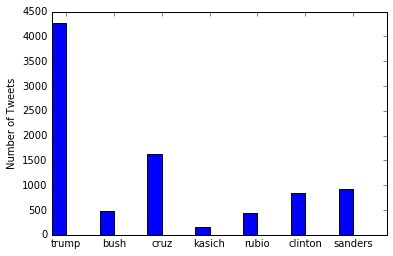

In [249]:
candidate_tweets = []
pos_tweets = []
neg_tweets = []
for i,val in enumerate(index_store):
    candidate_tweets.append(len(index_store[i]))
    pos_tweets.append(len(store_ind_pos_polarity[i]))
    neg_tweets.append(len(store_ind_neg_polarity[i]))
    
fig = plt.gcf()
matplotlib.rc('xtick',labelsize = 10)
matplotlib.rc('ytick',labelsize = 10)
# matplotlib.rc('ylabel',labelsize = 2b0)
plt.ylabel('Number of Tweets')
ind = np.arange(len(candidates))
width = .3
rect1 = plt.bar(ind, candidate_tweets, width, color = 'blue')
plt.xticks(ind+.3, candidates);

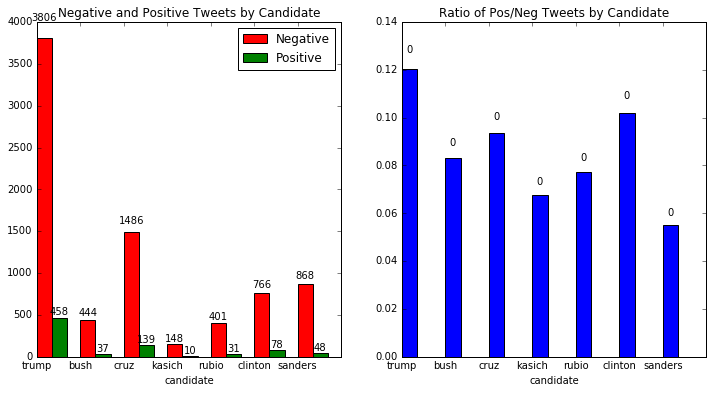

In [255]:
ind = np.arange(len(candidates))  # the x locations for the groups
width = 0.35       # the width of the bars
from matplotlib import gridspec
fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 4]) 
ax[0] = plt.subplot(gs[0])
rects1 = ax[0].bar(ind, neg_tweets, width, color='r') #, yerr=menStd
rects2 = ax[0].bar(ind + width, pos_tweets, width, color='g') #, yerr=womenStd


# add some text for labels, title and axes ticks
# plt.set_ylabel('Number of Tweets')
# plt.set_title('Negative and Positive Tweets by Candidate')
# plt.set_xticks(ind + width)
# plt.set_xticklabels(candidates)
ax[0].set_title('Negative and Positive Tweets by Candidate')

ax[0].legend((rects1[0], rects2[0]), ('Negative', 'Positive'))
ax[0].set_xlabel("candidate")
ax[0].set_xticklabels(candidates)

def autolabel(rects,axNum):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax[axNum].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1,0)
autolabel(rects2,0)

ax[1] = plt.subplot(gs[1])

ax[1].set_title('Ratio of Pos/Neg Tweets by Candidate')
ind = np.arange(len(candidates))
# width = .3
rect1 = ax[1].bar(ind, pos_neg_ratio, width, color = 'blue')
# ax[1].xticks(ind+.3, candidates);
ax[1].set_xlabel("candidate")
ax[1].set_xticklabels(candidates)
def autolabel2(rects,axNum):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax[axNum].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % height,
                ha='center', va='bottom')

autolabel2(rect1,1)
plt.show()


In [222]:
ax[0]

//anaconda/lib/python3.5/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


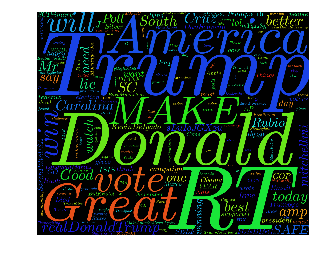

In [163]:
tempwordcloud = makeWordcloud(store_tweet_pos_polarity[0])

//anaconda/lib/python3.5/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


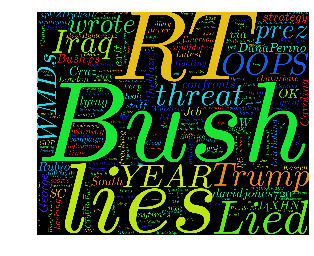

In [164]:
tempwordcloud = makeWordcloud(store_tweet_pos_polarity[1])

//anaconda/lib/python3.5/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


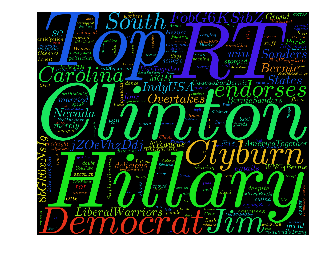

In [165]:
tempwordcloud = makeWordcloud(store_tweet_pos_polarity[2])

//anaconda/lib/python3.5/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


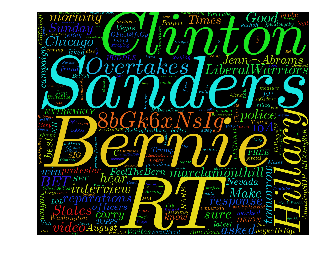

In [166]:
tempwordcloud = makeWordcloud(store_tweet_pos_polarity[3])

//anaconda/lib/python3.5/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


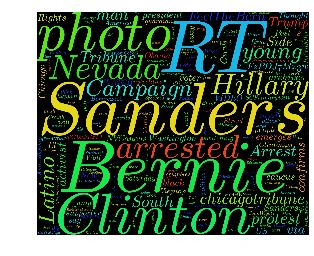

In [167]:
tempwordcloud = makeWordcloud(store_tweet_neg_polarity[3])

In [168]:
tweetBlob = TextBlob(joinedTexts)
candidates = ['Trump','Clinton','Kasich','Sanders','Bush','Cruz','Rubio']
storecount = [];
for i in candidates:
#     print(i)
    storecount.append(test.words.count(i))
fig = plt.gcf()
matplotlib.rc('xtick',labelsize = 25)
matplotlib.rc('ytick',labelsize = 20)
# matplotlib.rc('ylabel',labelsize = 20)
plt.ylabel('Number of Tweets')
ind = np.arange(len(candidates))
rect1 = plt.bar(ind, storecount, .3, color = 'blue')
plt.xticks(ind+.15, candidates);

NameError: name 'test' is not defined

## Plot geographical coordinates of tweets

In [ ]:
# This just lets the output of the following code samples
#  display inline on this page, at an appropriate size.
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (10,20)

In [ ]:
import matplotlib
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# setup Lambert Conformal basemap.
m = Basemap(projection='lcc',width=12000000,height=9000000,
            resolution='l',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
#draw boundary, fill ocean color
m.drawmapboundary(fill_color='#CCFFFF')
# fill continents, set lake color
m.fillcontinents(color='#66CC99',lake_color='#CCFFFF') # '#6699CC'
# draw parallels and meridians. label only on edges of map
parallels = np.arange(0.,81,10.)
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])
# drawstates, if no linewidth will be empty
m.drawstates(linewidth = .5)
m.drawcoastlines()
m.drawcountries()
# m.drawcounties(linewidth = 0.05, linestyle = 'solid', color = 'k', antialiased = 1)

i = 0
while i < len(coords):
    # get current coordinates 
    lon, lat = coords[i]
    # convert to map projection coords.
    # Note that lon,lat can be scalars, lists or numpy arrays.
    xpt,ypt = m(lon,lat)
    # convert back to lat/lon
    lonpt, latpt = m(xpt,ypt,inverse=True)
    m.plot(xpt,ypt,'ro')  # plot a blue dot there
    label = 'Hello'
    plt.Text(xpt+1000, ypt+5000, label)
    # put some text next to the dot, offset a little bit
    # (the offset is in map projection coordinates)
#     plt.text(xpt+100000,ypt+100000,'Boulder (%5.1fW,%3.1fN)' % (lonpt,latpt))
#     plt.text(xpt+100000,ypt+100000,'(%5.1fW,%3.1fN)' % (i,lonpt,latpt))
    i = i + 1
plt.show()

In [ ]:
rcParams['figure.figsize'] = (20,20)

 
# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1
# my_map = Basemap(projection='ortho', lat_0=50, lon_0=-100,
#               resolution='l', area_thresh=1000.0)
# my_map = Basemap(projection='robin', lat_0=50, lon_0=-100,
#               resolution='l', area_thresh=1000.0)
my_map = Basemap(projection='merc', lat_0=42.36, lon_0=-71.06,
              resolution='h', area_thresh=.01, 
              llcrnrlon=-71.3, llcrnrlat=42.1,
              urcrnrlon=-70.9, urcrnrlat=42.6) 
#               llcrnrlon=-71.098709, llcrnrlat=42.328093,
#               urcrnrlon=-71.012192, urcrnrlat=42.389994) 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color='#66CC99')
my_map.drawstates(linewidth = .5)
my_map.drawmapboundary()
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))
# my_map.drawcounties(linewidth = 0.5)

# lon = -135.3318
# lat = 57.0799
# x,y = my_map(lon, lat)
# my_map.plot(x, y, 'bo', markersize=12)
i = 0
while i < len(coords):
    # get current coordinates 
    lon, lat = coords[i]
    # convert to map projection coords.
    # Note that lon,lat can be scalars, lists or numpy arrays.
    xpt,ypt = my_map(lon,lat)
    # convert back to lat/lon
    lonpt, latpt = my_map(xpt,ypt,inverse=True)
    my_map.plot(xpt,ypt,'ro')  # plot a blue dot there
    label = 'Hello'
    plt.Text(xpt+1000, ypt+5000, label)
    # put some text next to the dot, offset a little bit
    # (the offset is in map projection coordinates)
#     plt.text(xpt+100000,ypt+100000,'Boulder (%5.1fW,%3.1fN)' % (lonpt,latpt))
#     plt.text(xpt+100000,ypt+100000,'(%5.1fW,%3.1fN)' % (i,lonpt,latpt))
    i = i + 1
plt.show()

## Display wordcloud for tweet text

In [ ]:

# no_urls_no_tags = " ".join([word for word in words.split()
#                             if 'http' not in word
#                                 and not word.startswith('@')
#                                 and word != 'RT'
#                             ])

# join tweets into a single string
joinedTexts = " ".join(str(x) for x in texts)

In [ ]:
from wordcloud import WordCloud, STOPWORDS
newSTOP = STOPWORDS
# add stopwords to exclude from wordcloud - 
newSTOP.update(('co','https','t','RT','R','T','-RT','RT@'))

#generate wordcloud
wordcloud = WordCloud(font_path='/anaconda/envs/eq_env/lib/python3.5/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf',
                          stopwords=newSTOP,
                          background_color='white',
                          width=1700,
                          height=1400
                         ).generate(joinedTexts)
# display wordcloud
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

## Trying out the document clustering.... http://brandonrose.org/clustering

In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
# import mpld3

In [ ]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [ ]:

# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [ ]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in texts:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [ ]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print( 'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(texts) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

In [ ]:
terms = tfidf_vectorizer.get_feature_names()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print(dist)

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [ ]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [ ]:
clusters